- 매수 신호 : DMI지표인 PDI가 MDI지표보다 값이 크다면 즉, 선이 위에 있으면서 ADX 지표가 상승하고 있다면 이는 상승 추세임을 나타낸다. PDI가 MDI를 교차함은 상승추세의 시작으로 보고 ADX가 ADX 이동 평균선을 상향 돌파 시 신규 매수 포지션을 취한다.
- 매도 신호 : 1번에 의한 매수 신호를 청산하는 방법으로 PDI와 MDI값의 차이가 최고에 이르다가 두 선의 움직임이 반대로 꺽여지면서 ADX가 ADX의 이동평균 선을 하방 돌파시 매도 청산한다.

In [62]:
import pandas as pd
import ta

import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

In [63]:
# 데이터 프레임에 지표 추가
def add_indicator(upbit):
    adx_indicator = ta.trend.ADXIndicator(high=upbit['high_price'], low=upbit['low_price'], close=upbit['trade_price'], window=14)
    
    # Average Directional Index (ADX)
    upbit['ADX'] = adx_indicator.adx()
    # ADX 이동평균선
    upbit['SMA_10'] = upbit['ADX'].rolling(window=10).mean()
    
    # Plus Directional Indicator (+DI)
    upbit['PDI'] = adx_indicator.adx_pos()
    
    # Minus Directional Indicator (-DI)
    upbit['MDI'] = adx_indicator.adx_neg()

In [64]:
upbit_2023_origin = pd.read_csv('DATA/upbit_BTC_prices_2023_days.csv')
upbit_2023 = upbit_2023_origin.copy()

In [65]:
add_indicator(upbit_2023)

In [66]:
# 기간 조정, 필요한 열 추출하여 정제된 df 만들기
def upbit_cleaned_df(upbit, start_date, end_date):
    condition = (upbit['candle_date_time_utc'] >= start_date) & (upbit['candle_date_time_utc'] <= end_date)
    upbit = upbit[condition]
    upbit = upbit[['candle_date_time_utc', 'trade_price', 'ADX', 'SMA_10', 'PDI', 'MDI']]
    upbit = upbit.reset_index(drop=True)
    return upbit

In [67]:
upbit_2023 = upbit_cleaned_df(upbit_2023, '2023-01-01', '2023-12-31')

In [68]:
# 샹향돌파, 하향돌파를 기준으로 잡기 때문에 값의 차이의 부호를 나타내는 새로운 열을 만든다.
def make_comparison_col(upbit, new_col, col1, col2):
    upbit[new_col] = upbit.apply(lambda row: '+' if row[col1] - row[col2] >= 0 else '-', axis=1)
    upbit[f'{new_col}_shift'] = upbit[new_col].shift(-1)

In [69]:
make_comparison_col(upbit_2023, 'comparison_PDI', 'PDI', 'MDI')
make_comparison_col(upbit_2023, 'comparison_ADX', 'ADX', 'SMA_10')

In [70]:
# 더 정확한 매수 신호를 잡고 싶다면
# def get_cross_signal(upbit, col1, col2):
#     condition1 = (upbit[col1] == '-') & (upbit[col1].shift(-1) == '+')
#     condition2 = (upbit[col2] == '-') & (upbit[col2].shift(-1) == '+')
#     upbit.loc[condition1 & condition2] = 'buy'
    
#     upbit.loc[(upbit[col2] == '+') & (upbit[col2].shift(-1) == '-'), 'buy_sell'] = 'sell'
#     upbit['buy_sell'] = upbit['buy_sell'].shift()

In [71]:
# 앞서 만든 부호로 매수, 매도 신호를 찾는다.
def get_cross_signal(upbit, col1, col2):
    upbit.loc[(upbit[col1] == '-') & (upbit[col1].shift(-1) == '+'), 'buy_sell'] = 'buy'  
    upbit.loc[(upbit[col2] == '+') & (upbit[col2].shift(-1) == '-'), 'buy_sell'] = 'sell'
    upbit['buy_sell'] = upbit['buy_sell'].shift()

In [72]:
get_cross_signal(upbit_2023, 'comparison_PDI', 'comparison_ADX')

In [73]:
# 매수, 매도 사인이 난 시점만 추출한다.
def get_DI_strategy_df(upbit):
    DI_strategy = upbit.loc[(upbit['buy_sell'] == 'buy') | (upbit['buy_sell'] == 'sell')].reset_index(drop=True)
    return DI_strategy

In [74]:
DI_strategy_2023 = get_DI_strategy_df(upbit_2023)

In [75]:
# buy, buy, sell 이런식이라면 첫번째 buy에서 사고 중간에 buy는 무시하고 첫번째 buy와 sell을 비교한다.
def get_trade_lst_idx(DI_strategy):
    signals = DI_strategy['buy_sell'].tolist()
    
    trade_lst_idx = []
    
    for i, signal in enumerate(signals):
        if signal == 'buy':
            temp = []
            temp.append(i)
            for j, signal in enumerate(signals[i+1:]):
                if signal == 'sell':
                    temp.append(j+i+1)
                    trade_lst_idx.append(temp)
                    break
        else:
            continue
   
    # for i in range(len(trade_lst_idx)-1):
    #     if i+1 <= len(trade_lst_idx)-1:
    #         if trade_lst_idx[i][1] > trade_lst_idx[i+1][0]:
    #             del trade_lst_idx[i+1]
    while True:
        temp = trade_lst_idx.copy()
        for i in range(len(trade_lst_idx)-1):
            if i+1 <= len(trade_lst_idx)-1:
                if trade_lst_idx[i][1] > trade_lst_idx[i+1][0]:
                    del trade_lst_idx[i+1]
        if temp == trade_lst_idx:
            break
    
    trade_lst_idx_cleaned = []
    for i in trade_lst_idx:
        for j in range(2):
            trade_lst_idx_cleaned.append(i[j])
            
    return trade_lst_idx_cleaned

In [76]:
trade_lst_idx_cleaned = get_trade_lst_idx(DI_strategy_2023)

In [77]:
# 앞서 정리한 매수, 매도 시점으로부터 수익데이터가 포함된 데이터 프레임을 반환한다.
def get_DI_strategy_profit(DI_strategy, trade_lst_idx_cleaned):
    DI_strategy_signal = DI_strategy.iloc[trade_lst_idx_cleaned]
    DI_strategy_signal
    
    DI_strategy_signal_final = DI_strategy_signal[['candle_date_time_utc', 'trade_price', 'buy_sell']]
    DI_strategy_signal_final_pivot = DI_strategy_signal_final.pivot(index='candle_date_time_utc', columns='buy_sell', values='trade_price')
    
    for_merge = (DI_strategy_signal_final_pivot['sell'].shift(-1) - DI_strategy_signal_final_pivot['buy']).shift().dropna().to_frame().rename(columns={0:'profit'})
    
    DI_strategy_profit = DI_strategy_signal_final_pivot.merge(for_merge, left_index=True, right_index=True, how='left')
    DI_strategy_profit['profit_percentage'] = (DI_strategy_profit['profit'] / DI_strategy_profit['buy'].shift()) * 100
    return DI_strategy_profit

In [78]:
DI_strategy_profit_2023 = get_DI_strategy_profit(DI_strategy_2023, trade_lst_idx_cleaned)

In [79]:
# 전략의 수익률을 간단하게 출력하여 성과를 나타낸다.
def get_prod_mean(DI_strategy_profit):
    prod = ((1 + DI_strategy_profit['profit_percentage'].dropna() / 100).prod() - 1) * 100 # 누적 수익률
    mean = DI_strategy_profit['profit_percentage'].mean() # 평균 수익률
    print(f"누적수익률 : {prod} %")
    print(f"평균수익률 : {mean} %")
    return prod, mean

In [80]:
prod_2023, mean_2023 = get_prod_mean(DI_strategy_profit_2023)

누적수익률 : 95.58496257612661 %
평균수익률 : 12.941196087582542 %


In [81]:
# 전체적인 가격 흐름과 매수, 매도 시점을 비교하여 성능을 한눈에 파악한다.
def plot_buy_and_sell(DI_strategy_profit, upbit, year):
    plt.figure(figsize=(20, 10))
    
    DI_strategy_profit.index = pd.to_datetime(DI_strategy_profit.index)
    
    vlines_buy = DI_strategy_profit['buy'].dropna().index
    vlines_sell = DI_strategy_profit['sell'].dropna().index

    upbit['candle_date_time_utc'] = pd.to_datetime(upbit['candle_date_time_utc'])
    upbit.set_index('candle_date_time_utc', inplace=True)
    
    ax = plt.plot(upbit['trade_price'], color='green', label='price')
    
    for i, vline in enumerate(vlines_buy):
        if i == 0:
            plt.axvline(vline, color='red', label='buy')
        else:
            plt.axvline(vline, color='red')
    
    for i, vline in enumerate(vlines_sell):
        if i == 0:
            plt.axvline(vline, color='blue', label='sell')
        else:
            plt.axvline(vline, color='blue')
            
    plt.ticklabel_format(axis='y',useOffset=False, style='plain')
    plt.legend()
    plt.ylabel("price")
    plt.title(f"<{year}년도 DI 이용한 투자 전략 매매 포인트>", fontsize=25)
    plt.show()

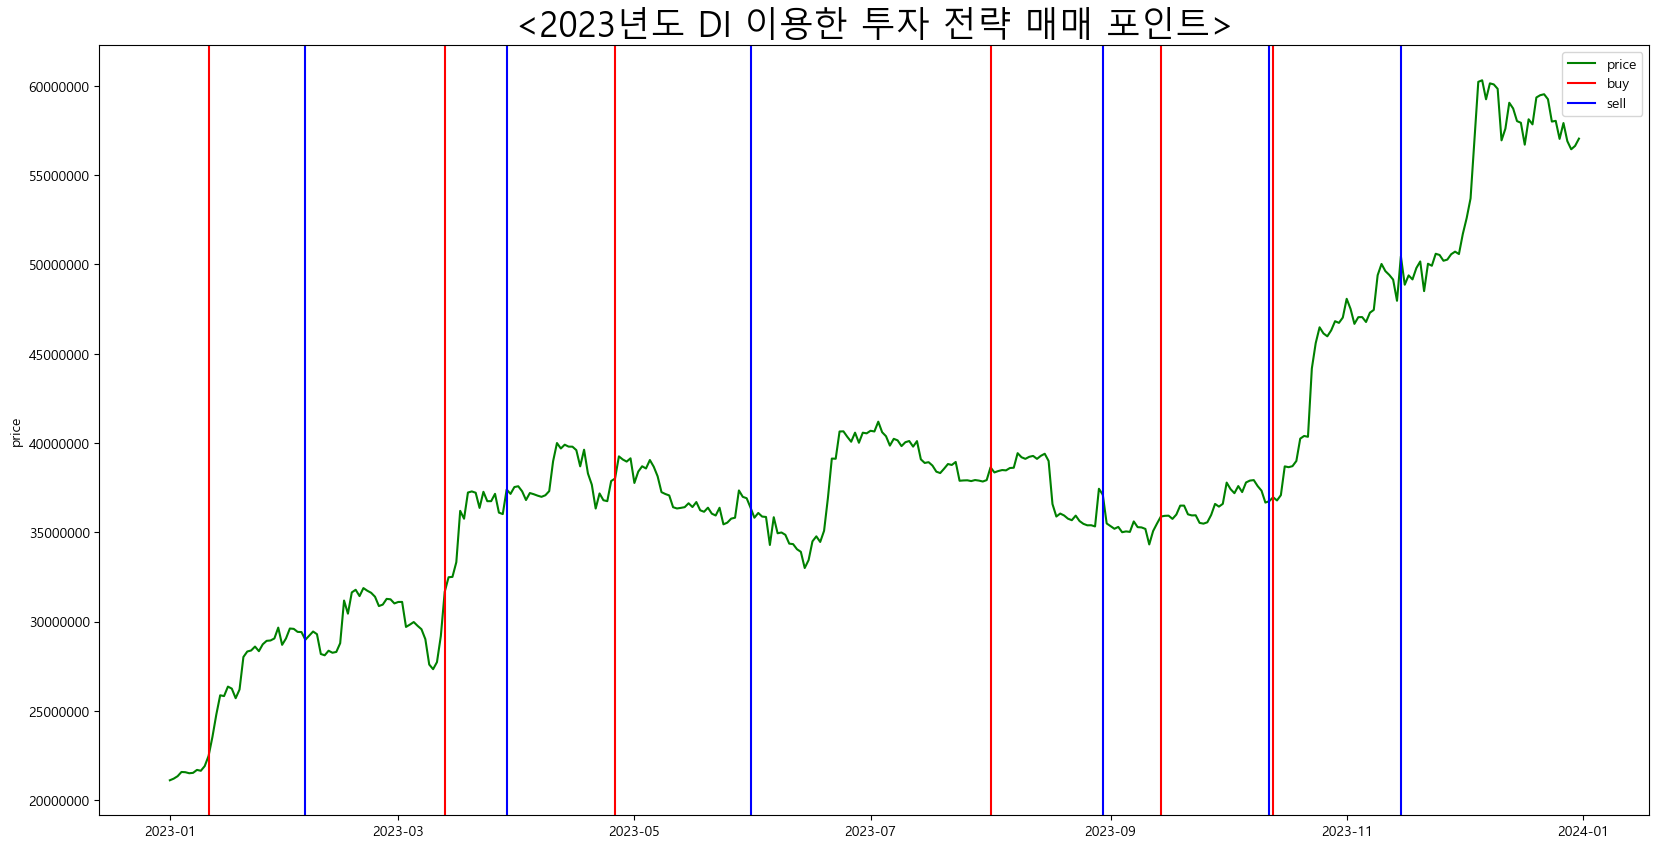

In [82]:
temp_upbit = pd.read_csv('DATA/upbit_BTC_prices_2023_days.csv')
add_indicator(temp_upbit)
temp_upbit = upbit_cleaned_df(temp_upbit, '2023-01-01', '2023-12-31')
plot_buy_and_sell(DI_strategy_profit_2023, temp_upbit, 2023)

In [83]:
upbit_2022_origin = pd.read_csv('DATA/upbit_BTC_prices_2022_days.csv')
upbit_2022 = upbit_2022_origin.copy()

In [84]:
add_indicator(upbit_2022)

upbit_2022 = upbit_cleaned_df(upbit_2022, '2022-01-01', '2022-12-31')

In [85]:
make_comparison_col(upbit_2022, 'comparison_PDI', 'PDI', 'MDI')
make_comparison_col(upbit_2022, 'comparison_ADX', 'ADX', 'SMA_10')

In [86]:
get_cross_signal(upbit_2022, 'comparison_PDI', 'comparison_ADX')

In [87]:
DI_strategy_2022 = get_DI_strategy_df(upbit_2022)

trade_lst_idx_cleaned = get_trade_lst_idx(DI_strategy_2022)

DI_strategy_profit_2022 = get_DI_strategy_profit(DI_strategy_2022, trade_lst_idx_cleaned)

In [88]:
prod_2022, mean_2022 = get_prod_mean(DI_strategy_profit_2022)

누적수익률 : -55.53732282260797 %
평균수익률 : -7.717112820239698 %


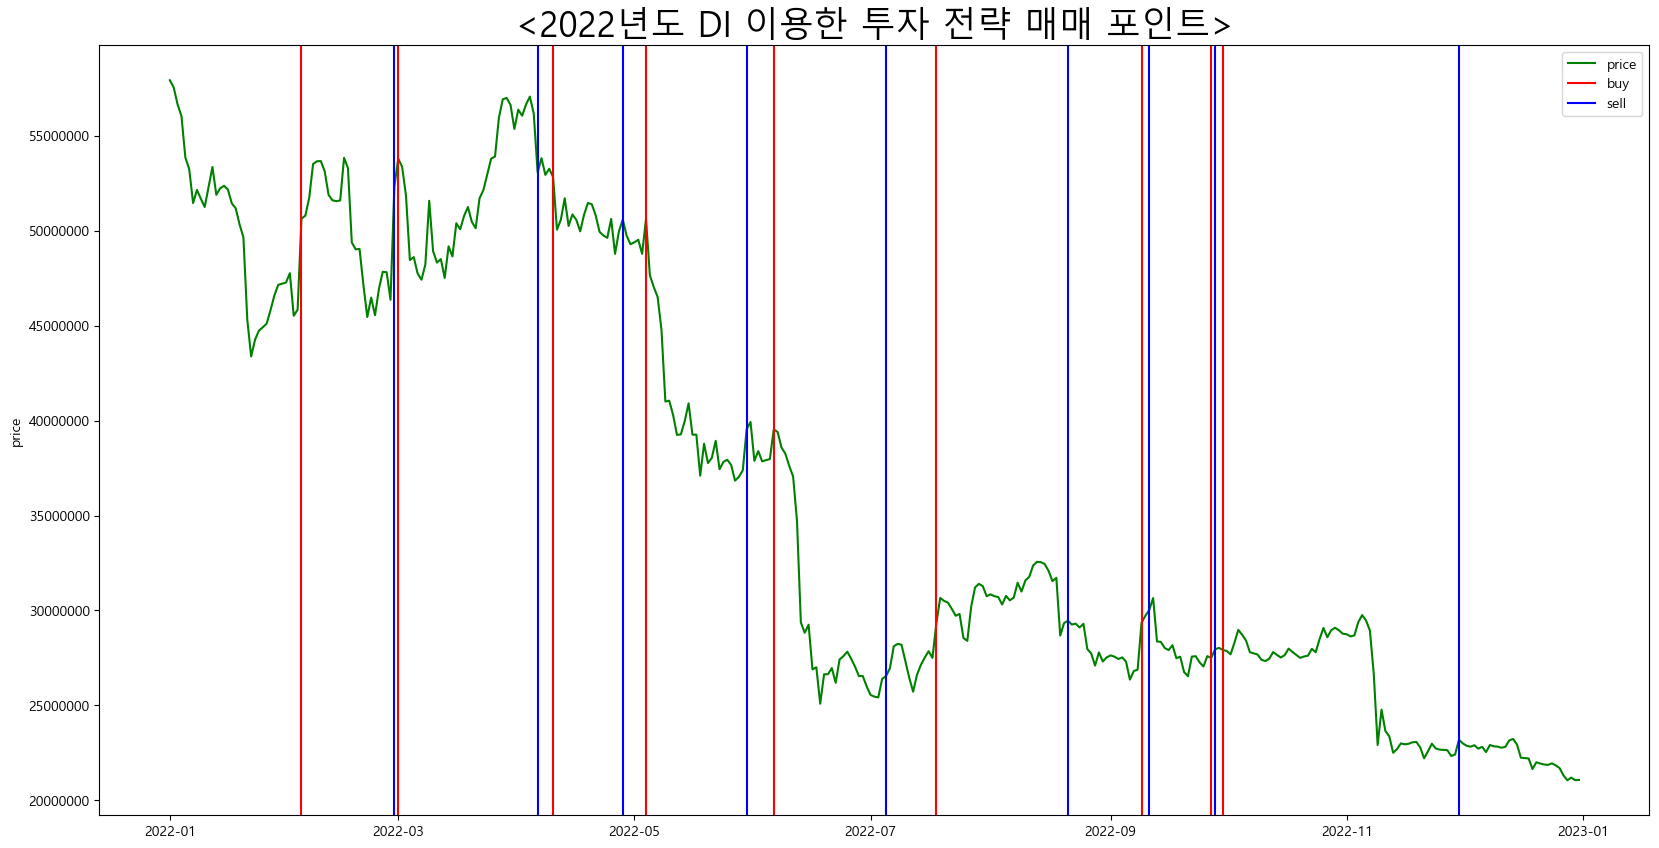

In [91]:
temp_upbit = pd.read_csv('DATA/upbit_BTC_prices_2022_days.csv')
add_indicator(temp_upbit)
temp_upbit = upbit_cleaned_df(temp_upbit, '2022-01-01', '2022-12-31')
plot_buy_and_sell(DI_strategy_profit_2022, temp_upbit, 2022)

In [92]:
DI_strategy_profit_2022

,buy,sell,profit,profit_percentage
candle_date_time_utc,,,,
2022-02-04,50633000.0,NaN,NaN,NaN
2022-02-28,NaN,52332000.0,1699000.0,3.355519
2022-03-01,53790000.0,NaN,NaN,NaN
2022-04-06,NaN,53072000.0,-718000.0,-1.334821
2022-04-10,52819000.0,NaN,NaN,NaN
2022-04-28,NaN,50580000.0,-2239000.0,-4.239005
2022-05-04,50616000.0,NaN,NaN,NaN
2022-05-30,NaN,39550000.0,-11066000.0,-21.862652
2022-06-06,39532000.0,NaN,NaN,NaN


In [93]:
DI_temp = DI_strategy_profit_2022.shift(-1)
DI_temp[DI_temp['profit_percentage'] > 1].index

DatetimeIndex(['2022-02-04', '2022-09-09', '2022-09-27'], dtype='datetime64[ns]', name='candle_date_time_utc', freq=None)

In [94]:
DI_strategy_profit_2022[DI_strategy_profit_2022['profit_percentage'] > 1].index

DatetimeIndex(['2022-02-28', '2022-09-11', '2022-09-28'], dtype='datetime64[ns]', name='candle_date_time_utc', freq=None)

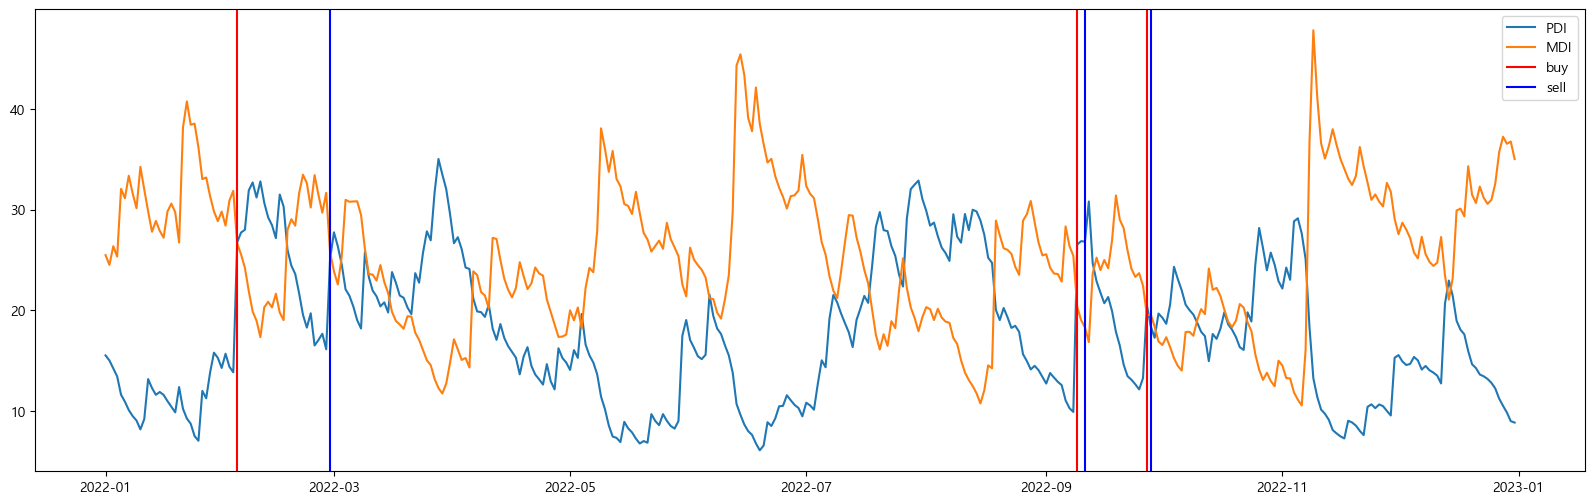

In [95]:
# 1% 이상 수익 발생했던 때 매매 시점
plt.figure(figsize=(20, 6))

DI_temp = DI_strategy_profit_2022.shift(-1)
vlines_buy = DI_temp[DI_temp['profit_percentage'] > 1].index


vlines_sell = DI_strategy_profit_2022[DI_strategy_profit_2022['profit_percentage'] > 1].index

plt.plot(temp_upbit[['PDI', 'MDI']], label=['PDI', 'MDI'])

for i, vline in enumerate(vlines_buy):
    if i == 0:
        plt.axvline(vline, color='red', label='buy')
    else:
        plt.axvline(vline, color='red')

for i, vline in enumerate(vlines_sell):
    if i == 0:
        plt.axvline(vline, color='blue', label='sell')
    else:
        plt.axvline(vline, color='blue')

plt.legend()
plt.show()

In [96]:
# 장이 좋을 때는 덩달아 좋지만 장이 안 좋으면 안 좋다.

In [97]:
# 년도별로 받아오기
years = ['2018', '2019', '2020', '2021']
upbits = []

for year in years:
    df = pd.read_csv(f'DATA/upbit_{year}_1d_krw_BTC.csv')
    # add_indicator(df)
    # df = upbit_cleaned_df(df, f'{year}-01-01', f'{year}-12-31')
    upbits.append(df)

upbit = pd.concat(upbits, ignore_index=True).drop_duplicates(ignore_index=True)
upbit

FileNotFoundError: [Errno 2] No such file or directory: 'DATA/upbit_2018_1d_krw_BTC.csv'

In [ ]:
# 2020년 윤년
add_indicator(upbit)
upbit = upbit_cleaned_df(upbit, '2018-01-01', '2021-12-31')
upbit

,candle_date_time_utc,trade_price,ADX,SMA_10,PDI,MDI
0,2018-01-01,18860000.0,23.909914,2.390991,21.677876,18.333189
1,2018-01-02,20263000.0,23.719916,4.762983,25.863190,16.797764
2,2018-01-03,20900000.0,23.543489,7.117332,24.612185,15.985254
3,2018-01-04,23402000.0,24.185063,9.535838,28.164512,14.339771
4,2018-01-05,27444000.0,25.951847,12.131023,35.613665,12.215578
...,...,...,...,...,...,...
1456,2021-12-27,61508000.0,31.908270,37.478339,19.347897,25.709781
1457,2021-12-28,58274000.0,31.698878,36.575142,17.396696,31.592061
1458,2021-12-29,57089000.0,31.870652,35.694552,16.353099,33.279737
1459,2021-12-30,57200000.0,32.101543,34.815623,15.485273,32.237434


In [ ]:
make_comparison_col(upbit, 'comparison_PDI', 'PDI', 'MDI')
make_comparison_col(upbit, 'comparison_ADX', 'ADX', 'SMA_10')

In [ ]:
get_cross_signal(upbit, 'comparison_PDI', 'comparison_ADX')

DI_strategy_total = get_DI_strategy_df(upbit)

trade_lst_idx_cleaned = get_trade_lst_idx(DI_strategy_total)

DI_strategy_profit_total = get_DI_strategy_profit(DI_strategy_total, trade_lst_idx_cleaned)

In [ ]:
prod_total, mean_total = get_prod_mean(DI_strategy_profit_total)

누적수익률 : 94.38289476850679 %
평균수익률 : 7.878282772489445 %


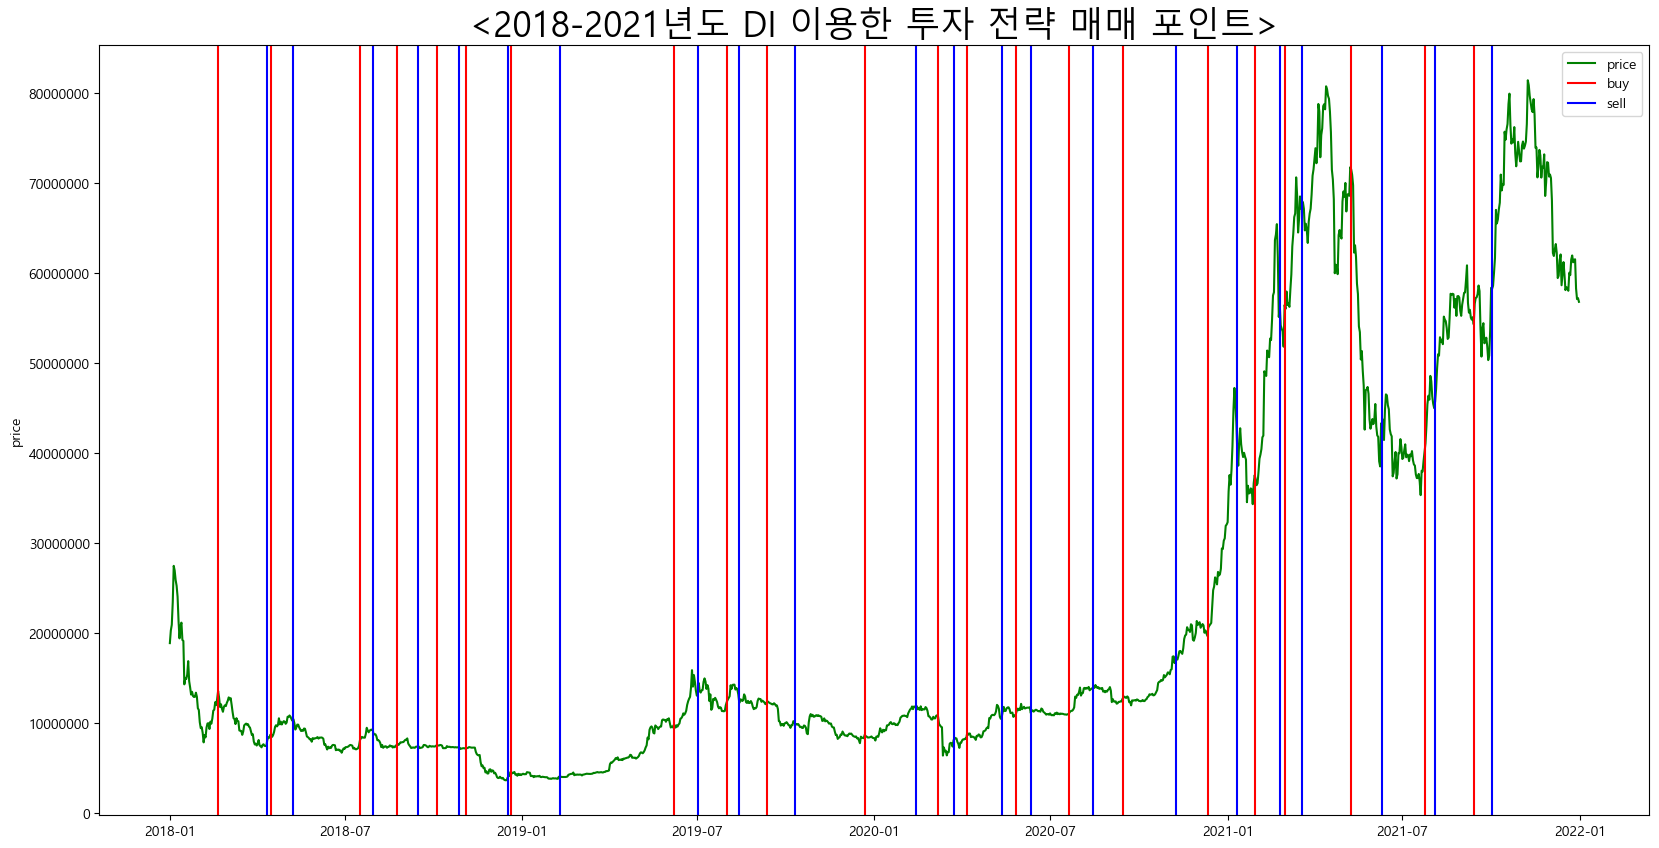

In [ ]:
plot_buy_and_sell(DI_strategy_profit_total, upbit, '2018-2021')

In [ ]:
# 전체적인 가격 흐름과 매수, 매도 시점을 비교하여 성능을 한눈에 파악한다.
def plot_buy_and_sell_dot(DI_strategy_profit, upbit, year):
    plt.figure(figsize=(20, 10))
    
    DI_strategy_profit.index = pd.to_datetime(DI_strategy_profit.index)
    
    buy_date = DI_strategy_profit['buy'].dropna().index
    buy_price = DI_strategy_profit['buy'].dropna().values
    
    sell_date = DI_strategy_profit['sell'].dropna().index
    sell_price = DI_strategy_profit['sell'].dropna().values

    upbit = upbit.copy()
    upbit['candle_date_time_utc'] = pd.to_datetime(upbit['candle_date_time_utc'])
    upbit.set_index('candle_date_time_utc', inplace=True)
    
    ax = plt.plot(upbit['trade_price'], color='green', label='price')
    plt.scatter(buy_date, buy_price, color='red', label='buy', s=75)
    plt.scatter(sell_date, sell_price, color='blue', label='sell', s=75)
            
    plt.ticklabel_format(axis='y',useOffset=False, style='plain')
    plt.legend()
    plt.ylabel("price")
    plt.title(f"<{year}년도 DI 이용한 투자 전략 매매 포인트>", fontsize=25)
    plt.show()

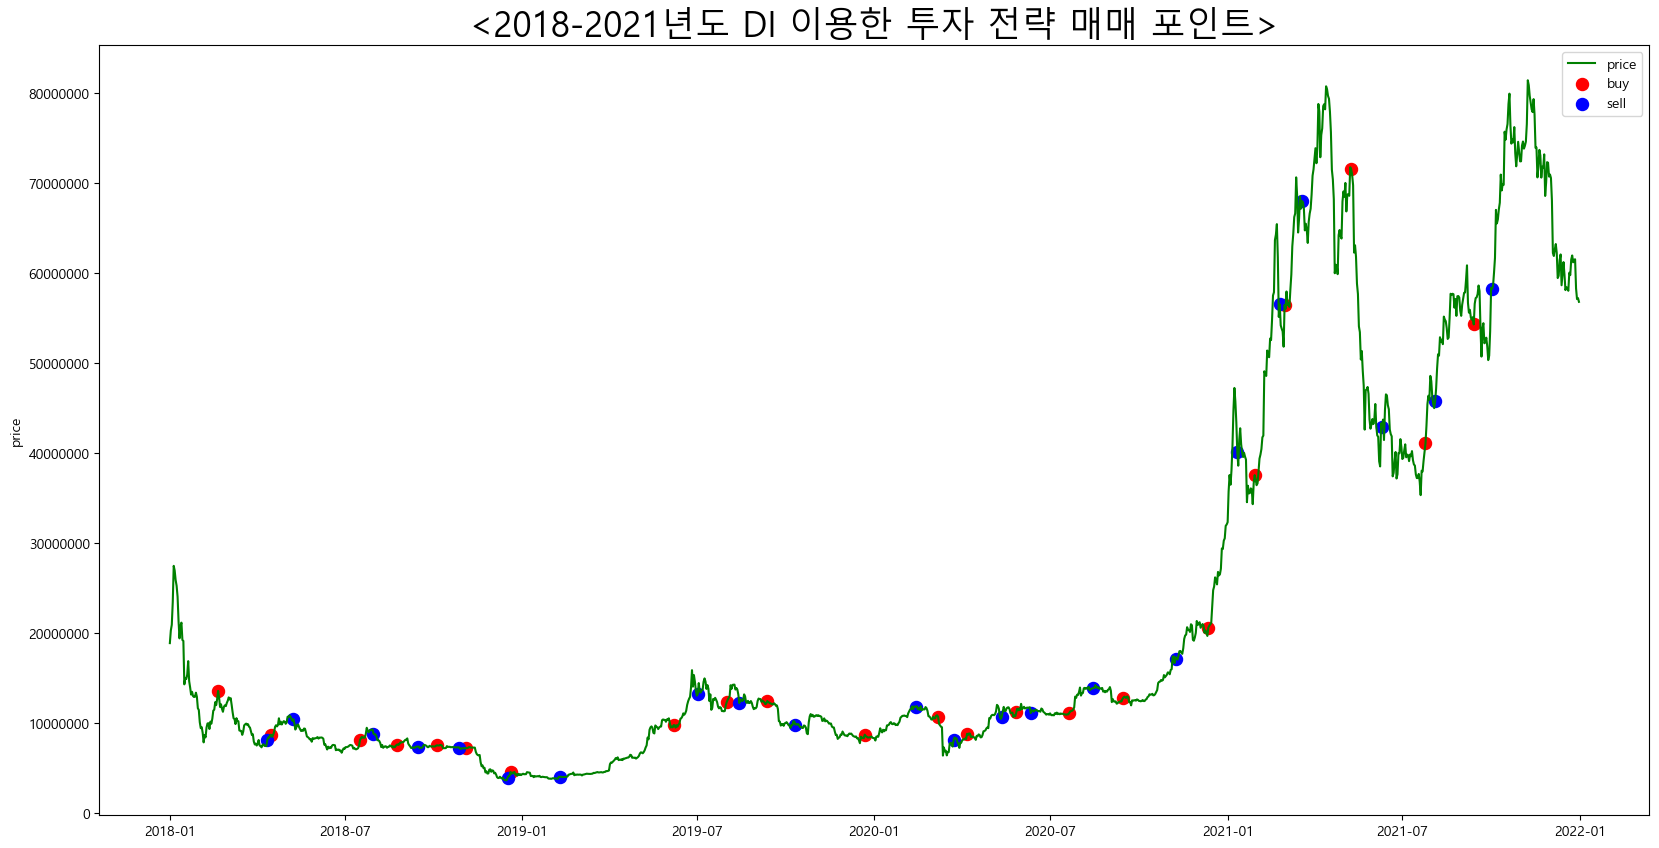

In [ ]:
plot_buy_and_sell_dot(DI_strategy_profit_total, upbit, '2018-2021')

In [ ]:
# 평균 수익률
DI = DI_strategy_profit_total.reset_index()
DI['year'] = DI['candle_date_time_utc'].dt.year
DI.groupby('year')['profit_percentage'].mean()

year
2018   -10.422388
2019     0.329712
2020    15.035988
2021    24.053628
Name: profit_percentage, dtype: float64

In [ ]:
# 누적 수익률
DI['prod'] = (DI['profit_percentage'] / 100 + 1)
(DI.groupby('year')['prod'].prod() - 1) * 100

year
2018    -59.826529
2019     -6.926787
2020    105.672367
2021    152.765638
Name: prod, dtype: float64

In [ ]:
years = ['2018', '2019', '2020', '2021', '2022', '2023']
upbits = []

for year in years:
    df = pd.read_csv(f'DATA/upbit_{year}_1d_krw_BTC.csv')
    upbits.append(df)

upbit = pd.concat(upbits, ignore_index=True).drop_duplicates(ignore_index=True)
upbit

,market,candle_date_time_utc,candle_date_time_kst,opening_price,high_price,low_price,trade_price,timestamp,candle_acc_trade_price,candle_acc_trade_volume,prev_closing_price,change_price,change_rate
0,KRW-BTC,2017-12-05,2017-12-05T09:00:00,13683000.0,14794000.0,13612000.0,14645000.0,1512518400020,3.933544e+11,27842.824832,13684000.0,961000.0,0.070228
1,KRW-BTC,2017-12-06,2017-12-06T09:00:00,14645000.0,19006000.0,14645000.0,18390000.0,1512604740000,7.644868e+11,46874.815723,14645000.0,3745000.0,0.255719
2,KRW-BTC,2017-12-07,2017-12-07T09:00:00,18389000.0,23860000.0,17965000.0,23791000.0,1512691200081,1.118270e+12,55171.056944,18390000.0,5401000.0,0.293692
3,KRW-BTC,2017-12-08,2017-12-08T09:00:00,23795000.0,24967000.0,16521000.0,20260000.0,1512777600070,2.070532e+12,101681.962251,23791000.0,-3531000.0,-0.148417
4,KRW-BTC,2017-12-09,2017-12-09T09:00:00,20259000.0,20877000.0,15257000.0,17769000.0,1512864000151,1.017294e+12,57286.612720,20260000.0,-2491000.0,-0.122952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2213,KRW-BTC,2023-12-27,2023-12-27T09:00:00,57032000.0,58212000.0,56349000.0,57920000.0,1703721598803,2.270096e+11,3965.842823,57032000.0,888000.0,0.015570
2214,KRW-BTC,2023-12-28,2023-12-28T09:00:00,57920000.0,58468000.0,56700000.0,56907000.0,1703807999951,2.269573e+11,3958.816736,57920000.0,-1013000.0,-0.017490
2215,KRW-BTC,2023-12-29,2023-12-29T09:00:00,56904000.0,57300000.0,56000000.0,56450000.0,1703894399762,2.419572e+11,4273.270718,56907000.0,-457000.0,-0.008031
2216,KRW-BTC,2023-12-30,2023-12-30T09:00:00,56450000.0,57150000.0,56101000.0,56639000.0,1703980799652,1.301367e+11,2301.724829,56450000.0,189000.0,0.003348


In [ ]:
# 2020년 윤년
add_indicator(upbit)
upbit = upbit_cleaned_df(upbit, '2018-01-01', '2023-12-31')
upbit

,candle_date_time_utc,trade_price,ADX,SMA_10,PDI,MDI
0,2018-01-01,18860000.0,23.909914,2.390991,21.677876,18.333189
1,2018-01-02,20263000.0,23.719916,4.762983,25.863190,16.797764
2,2018-01-03,20900000.0,23.543489,7.117332,24.612185,15.985254
3,2018-01-04,23402000.0,24.185063,9.535838,28.164512,14.339771
4,2018-01-05,27444000.0,25.951847,12.131023,35.613665,12.215578
...,...,...,...,...,...,...
2186,2023-12-27,57920000.0,24.173608,30.317814,17.771379,23.667198
2187,2023-12-28,56907000.0,23.239841,28.765434,17.526000,21.902958
2188,2023-12-29,56450000.0,22.846464,27.448236,16.549140,23.683399
2189,2023-12-30,56639000.0,22.481185,26.297408,15.784601,22.589271


In [ ]:
make_comparison_col(upbit, 'comparison_PDI', 'PDI', 'MDI')
make_comparison_col(upbit, 'comparison_ADX', 'ADX', 'SMA_10')

get_cross_signal(upbit, 'comparison_PDI', 'comparison_ADX')

DI_strategy_total = get_DI_strategy_df(upbit)

trade_lst_idx_cleaned = get_trade_lst_idx(DI_strategy_total)

DI_strategy_profit_total = get_DI_strategy_profit(DI_strategy_total, trade_lst_idx_cleaned)

prod_total, mean_total = get_prod_mean(DI_strategy_profit_total)

누적수익률 : 56.063271865895416 %
평균수익률 : 4.573840357218016 %


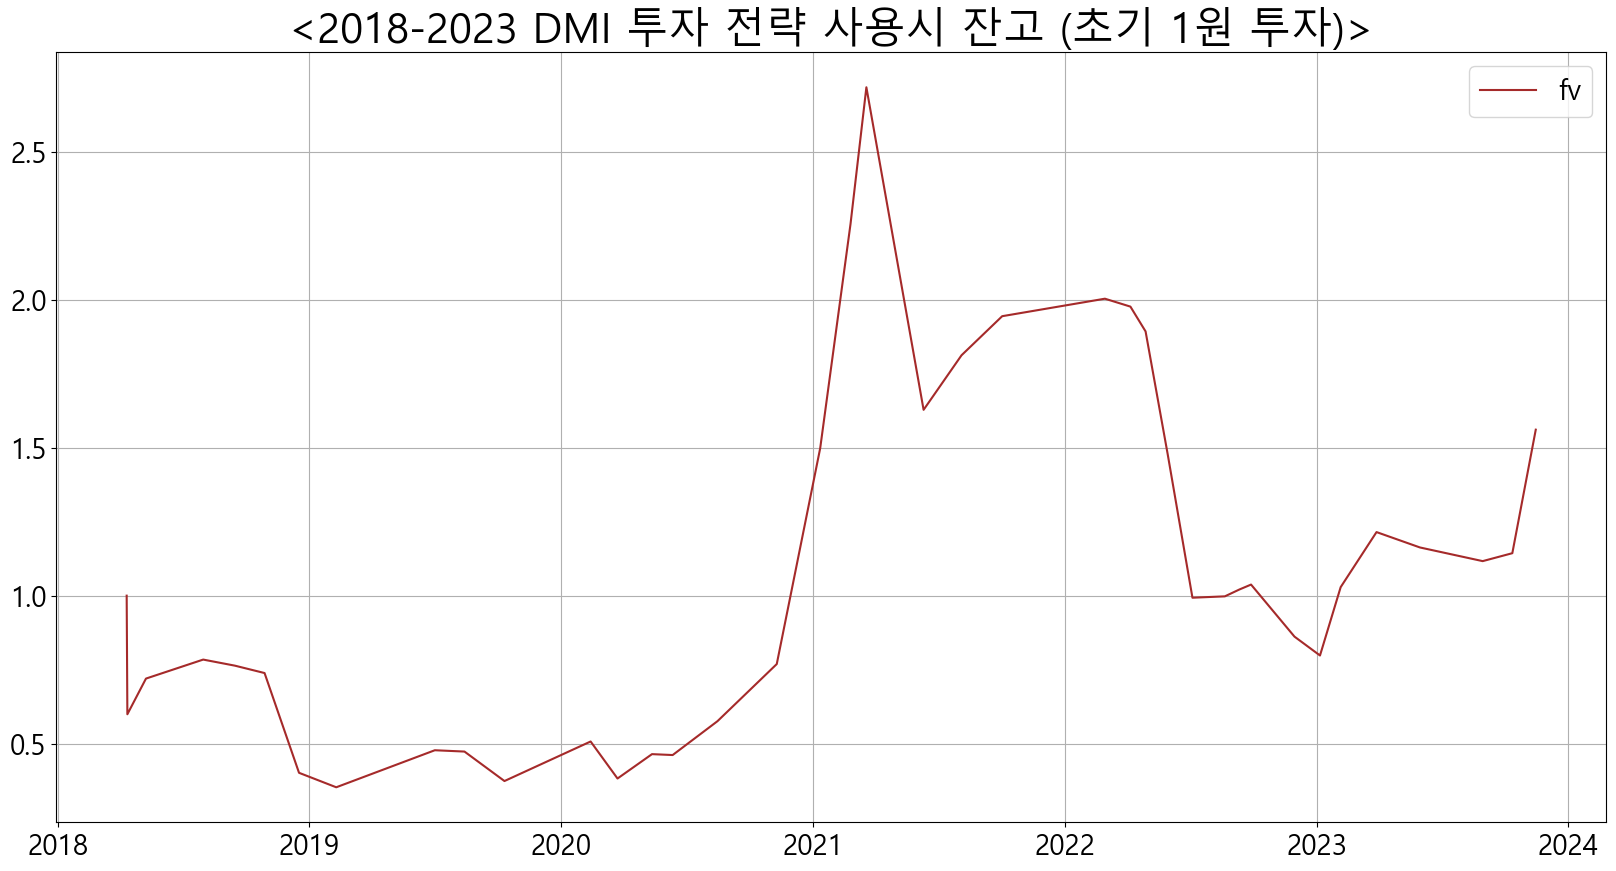

In [ ]:
from datetime import datetime, timedelta

total_profit_rate = pd.concat([pd.Series([1]), (1 + DI_strategy_profit_total['profit_percentage'].dropna() / 100).cumprod()])
idx = total_profit_rate.index.tolist()

# 문자열로 주어진 날짜
date_str = idx[1]
date_format = "%Y-%m-%d"

# 문자열을 datetime 객체로 변환
first_date = datetime.strptime(date_str, date_format)
before_date = first_date - timedelta(1)

# datetime 객체를 문자열로 변환
before_date_str = before_date.strftime(date_format)

idx[0] = before_date_str

total_profit_rate.index = idx

total_profit_rate = total_profit_rate.reset_index().rename(columns={0:'cumulative_profit_rate', 'index': 'datetime'})
total_profit_rate['datetime'] = pd.to_datetime(total_profit_rate['datetime'])

plt.figure(figsize=(20, 10))
plt.rc('font', size=20)
plt.plot(total_profit_rate.set_index('datetime'), label='fv', color='brown')
plt.title("<2018-2023 DMI 투자 전략 사용시 잔고 (초기 1원 투자)>", fontsize=30)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()